# prologue

### set up notebook and load package

In [1]:
# for notebook plotting
%matplotlib inline 

# load what we need
import time
import timeit
import numpy as np
import sklearn
import sklearn.dummy as dummy
import CHIRPS.structures as strcts
import CHIRPS.datasets as ds
import CHIRPS.datasets_proprietary as dsp
import CHIRPS.routines as rt

# demo datasets that ship with package. all from UCI unless stated otherwise
# import CHIRPS.datasets as ds
# ds.adult_data, ds.adult_samp_data, ds.adult_small_samp_data Large dataset ships with manageable sub samples
# ds.bankmark_data, ds.bankmark_samp_data
# ds.car_data
# ds.cardio_data this is the cardiotocography dataset
# ds.credit_data
# ds.german_data
# ds.lending_data, ds.lending_samp_data, ds.lending_small_samp_data, ds.lending_tiny_samp_data from Kaggle. see datasets_from_source file for links
# ds.nursery_data, ds.nursery_samp_data
# ds.rcdv_data, ds.rcdv_samp_data from US government see datasets_from_source file for links

### common config - can be ommitted if defaults are OK

In [2]:
# location to save results
project_dir = '/datadisk/whiteboxing/2020'
# project_dir = 'V:\\whiteboxing\\2020' # defaults to a directory "whiteboxing" in the working directory
# project_dir = 'C:\\Users\\Crutt\\Documents\\whiteboxing\\2020'

random_state_splits = 123 # one off for splitting the data into test / train
random_state = 123 # for everything else - e.g. building a new rf with same data

# Build a Random Forest Model to Predict and Explain
First, a wrapper is created for the dataset. Use one that ships with the package, or create your own.
Then split the data into training and (hold out) test set using the convenience functions in the package. These return an object that contain the split data in various representations, such as Pandas DataFrames and encoded, sparse matrices.

/home/julianhatwell/anaconda3/envs/B3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


using previous tuning parameters
Best OOB Accuracy Estimate during tuning: 0.7643
Best parameters:{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1600, 'subsample': 0.5, 'random_state': 123}

Confusion matrix, without normalization
[[ 52  36]
 [ 35 177]]


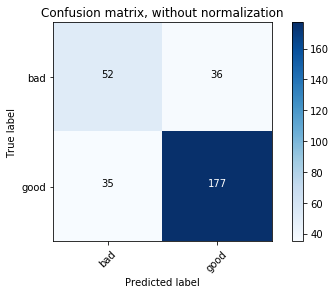

Normalized confusion matrix
[[0.59 0.41]
 [0.17 0.83]]


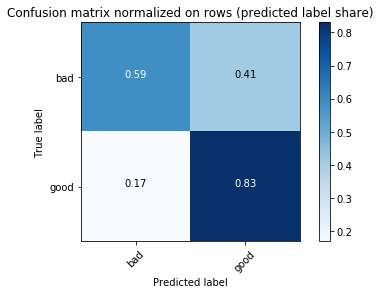

In [3]:
# load one of the included datasets
# project_dir will default to directory name CHIRPS in the working directory if not given
# random_state will default to 123
override_tuning = False
mydata = ds.german(random_state=random_state_splits, project_dir=project_dir)

meta_data = mydata.get_meta()
save_path = meta_data['get_save_path']()

# split the data. here using a basic sampling method.
# the returned object is a wrapper class that contains
# the train and test splits for X and y

# also the the encoded versions of X_train and X_test that the rf will use
# this is because we prefer onehot encoded over allowing categorical vars to be represented as integer
# scikit would treat these as ordinal, which is inappropriate

# also some meta-data: priors for y, the indexes from the input data

# also some convenience functions for leave-one-out testing

# train test split - one off hard-coded random state.
# random state can be ommitted 
# and will default to the state held in the dataset container
# which defaults to 123 if ommitted in the constructor
train_index, test_index = mydata.get_tt_split_idx(random_state=random_state_splits)
# optionally, indexes can be ommitted and will default to scikit's train_test_split method
tt = mydata.tt_split(train_index, test_index)

# CHOOSE ONE
# model = 'RandomForest'
# model = 'AdaBoost1' # SAMME
# model = 'AdaBoost2' # SAMME.R
model = 'GBM'

# decide if to run the whole tuning routine again (long for Adaboost)
# RF routine has a default tuning grid, so can leave as None, or come up with some other options
tuning = {'grid' : None, 'override' : override_tuning}
if model == 'RandomForest':
    which_trees = 'majority'
    tuning.update({'grid' : {'n_estimators': [(i + 1) * 200 for i in range(8)],
                            'max_depth' : [32]}})

elif model in ('AdaBoost1', 'AdaBoost2'):
    if model == 'AdaBoost1':
        # classic (and multi-class) AdaBoost
        algo = 'SAMME'
        which_trees = 'majority'
    else:
        algo = 'SAMME.R'
        which_trees = 'conf_weighted'
    max_depth = [i for i in range(1, 5)]
    tuning.update({'grid' : {'base_estimator' : [rt.DecisionTreeClassifier(max_depth=d) for d in max_depth],
                            'n_estimators': [(i + 1) * 200 for i in range(8)], 'algorithm': [algo]}})
    
else: # GBM - not fully implemented yet
    tuning.update({'grid' : {'subsample' : [0.5],
                        'n_estimators': [i * 200 for i in range(1, 9)],
                        'max_depth' : [i for i in range(1, 5)],
                        'learning_rate': np.full(4, 10.0)**[i for i in range(-3, 1)]}})

rf = rt.forest_prep(ds_container=tt,
                    meta_data=meta_data,
                    override_tuning=override_tuning,
                    model=model,
                    tuning_grid=tuning['grid'],
                    save_path=save_path,
                    plot_cm=True, plot_cm_norm=True)

In [4]:
# at the tree level
print(rf.estimators_[0][0].predict(tt.X_test_enc[0])[0])
print(rf.estimators_[0][0].apply(tt.X_test_enc[0])) # the leaf position
# the value in the leaf is the prediction
rf.estimators_[0][0].tree_.value[4][0][0]
tt.X_test_enc[0:3]



-0.8248495223467764
[3]


<3x61 sparse matrix of type '<class 'numpy.float64'>'
	with 60 stored elements in Compressed Sparse Row format>

In [5]:
# # step 0: choose an instance
# instance = tt.X_test_enc[0:5]

# # step 1: what is the initial guess f_0(x)
# # prior probas
# priors = mydata.data[meta_data['class_col']].value_counts(normalize=True)
# print('prior probas')
# print(priors)
# print()

# # all instances get the same init guess
# # predict the priors
# if type(rf.init_) == sklearn.dummy.DummyClassifier:
#     prior = rf.init_.predict_proba(instance)[0]
#     prior_odds = prior / (1 - prior)
#     prior_lodds = np.log(prior_odds)
# else:
#     # this is some windows bullshit. should be a dummy classifier with prior
#     # but instead it's a LogOddsClassifier
#     prior_lodds = rf.init_.predict(instance)[0][0]
#     prior_lodds = [-prior_lodds, prior_lodds] # lodds of class 1, needs to be symmetric for class 0
#     prior_odds = np.exp(prior_lodds)
#     prior = prior_odds / (1 + prior_odds)

# print('prior lodds, odds, probas(check)')
# print(prior_lodds)
# print(prior_odds)
# print(prior)
# print()

# # step 2: predicted results
# print('predicted lodds, odds, probas(check)')
# pred_proba = rf.predict_proba(instance)
# pred_odds = pred_proba / (1 - pred_proba)
# pred_lodds = np.log(pred_odds)
# print(pred_lodds)
# print(pred_odds)
# print(pred_proba)
# print()

# # step 3: which direction compared to initial guess? and how big of a step was it?
# print('diff predicted - prior')
# print('if pred lodds 0/1 is bigger(+ve)/smaller(-ve) then p(y = 0 | x) has increased')
# print('if pred lodds 0/1 is smaller(-ve)/bigger(+ve) then p(y = 1 | x) has increased')
# diff_lodds = pred_lodds - prior_lodds
# # diff_odds = np.exp(diff_lodds)
# # diff_proba = diff_odds / (1 + diff_odds)
# print(diff_lodds)
# # print('diff odds')
# # print(diff_odds)
# # print('diff proba')
# # print(diff_proba)
# # print(prior*diff_proba)
# print()

# # step 4: get the individual tree increments
# # a. staged decision function is the incremental change as the estimators are added, take the difference (include init)
# staged_lodds = [np.diff(np.append(prior_lodds[0], [np.log(sp[0][0]/sp[0][1]) for sp in rf.staged_predict_proba(i)])) \
#                 for i in instance]
# # b. get the predicted value from each individual estimator
# # step_lodds = [-(rf.estimators_[i][0].predict(instance) * 0.1)[0] for i in range(rf.estimators_.shape[0])]
# # delta_lodds = np.array([[stage, step] for stage, step in zip(staged_lodds, step_lodds)]).sum(axis=0) # these are the same (signed)

# # print('calculated delta lodds')
# # print(delta_lodds)
# # print('calculated final lodds, odds, probas(check)')
# # print([prior_lodds[0] + delta_lodds[0], prior_lodds[1] - delta_lodds[0]])

# # step 6: filter by sign
# print('indexer for the trees we want')
# tree_agree_maj_vote = [np.sign(staged_lodds[i]) == np.sign(diff_lodds[i][0]) for i in range(len(staged_lodds))]
# print(tree_agree_maj_vote[0])

# # the move from prior to final is important here.
# # final_lodds = prior_lodds + delta_lodds[1]  # this is where we end up with staged
# # print(final_lodds)
# # print(np.exp(final_lodds) / (1 + np.exp(final_lodds)))
# # print(rf.predict_proba(instance))

# Preparing unseen data

Again note:
test set has never been "seen" by random forest during training
test set has been only used to assess model (random forest) accuracy - no additional tuning after this
test set has not be involved in generating the explainer

## optional: memory and computation cost management
#### CHIRPS is time economical but memory intensive to compute for lots of instances at once
option 1: choose a smaller number of instances to explain

In [6]:
# control for async processes - each tree walk can be done in its own core
# and so can each explanation (e.g. rule conditions merge by hill-climbing)
# these will default to false if not passed explicitly to the explainer function
# on a multi-core machine there should be a good speed up for large batches
# when the batch_size advantage exceeds the overhead of setting up multi-processing
# timings will be printed to screen so you can see if it helps
forest_walk_async=True
chirps_explanation_async=True

# how many instances to explain in total from a test/unseen set
# doesn't matter if you don't know how large the dataset is
# this function prevents you maxing out, or put n_instances = None for whole dataset
n_instances = rt.n_instance_ceiling(ds_container=tt, n_instances=10)

# this gets the next batch out of the data_split_container according to the required number of instances
# all formats can be extracted, depending on the requirement
# unencoded, encoded (sparse matrix is the type returned by scikit), ordinary dense matrix also available
tt.current_row_test = 0
instances, _, instances_enc, instances_enc_matrix, labels = tt.get_next(n_instances, which_split='test') # default

option 2: just run the whole test set

In [7]:
# instances = tt.X_test; instances_enc = tt.X_test_enc; instances_enc_matrix = tt.X_test_enc_matrix; labels = tt.y_test

## Make predictions from the decision forest on the unseen data
Important point, no compromise on model accuracy

In [8]:
# get all the model predictions for the test instance(s) we're looking at
preds_idx = labels.index
preds = rf.predict(X=instances_enc)

# CHIRPS Step 1:
## Extract Tree Prediction Paths
### Fit a forest_walker object to the dataset and decision forest
This is a wrapper will extracts the paths of all the given instances. For CHIRPS, we want a large sample. The whole training set or other representative sample will do.

It can also report interesting statistics (treating the forest as a set of random tree-structured variables).

In [9]:
# wrapper object needs the decision forest itself and the dataset meta data (we have a convenience function for this)
f_walker = strcts.regression_trees_walker(forest = rf, meta_data=meta_data)

Now the work of extracting all the paths for each instance is done

In [10]:
print('Walking forest for ' + str(len(labels)) + ' instances... (please wait)')

# set the timer
forest_walk_start_time = timeit.default_timer()

# do the walk - creates a paths_container (even for just one instance) as a new property
# requires the X instances in a matrix (dense, ordinary numpy matrix) - this is available in the data_split_container
f_walker.forest_walk(instances = instances_enc_matrix
                    , labels = preds # we're explaining the prediction, not the true label!
                    , forest_walk_async = forest_walk_async)

# stop the timer
forest_walk_end_time = timeit.default_timer()
forest_walk_elapsed_time = forest_walk_end_time - forest_walk_start_time

print('Forest Walk with async = ' + str(forest_walk_async))
print('Forest Walk time elapsed:', "{:0.4f}".format(forest_walk_elapsed_time), 'seconds')

Walking forest for 10 instances... (please wait)
in DummyEstimator
Forest Walk with async = True
Forest Walk time elapsed: 1.0182 seconds


In [11]:
f_walker.path_detail[2][0]

{'estimator_weight': -0.8248495223467764,
 'pred_class': nan,
 'pred_class_label': '',
 'pred_proba': nan,
 'forest_pred_class': 0,
 'agree_maj_vote': True,
 'path': {'feature_idx': [3, 54],
  'feature_name': ['chk_A14', 'dur'],
  'feature_value': [0.0, 24.0],
  'threshold': [0.5, 11.5],
  'leq_threshold': [True, False]}}

In [12]:
stop

NameError: name 'stop' is not defined

In [ ]:
type(rf)

# CHIRPS Steps 2-4: 
## Freqent pattern mining of paths.
## Score and sort mined path segments.
## Merge path segments into one rule.

This is a wrapper object that will execute steps 2-4 on all the instance-paths in the batch_paths_container.

Note that true_divide warnings are OK. It just means that a continuous variable is unbounded in some way i.e. no greater/less than discontinuity is used in the CHIRPS explanation.

Note also, here we are using the training set to create the explainers. We could use a different dataset as long as it is representative of the training set that built the decision forest. Most important that we don't use the dataset that we wish to explain.

In [ ]:
chirps_explanation_async=False
# get what the model predicts on the training sample
sample_labels = rf.predict(tt.X_train_enc)

# build CHIRPS and a rule for each instance represented in the path detail
CHIRPS = strcts.CHIRPS_container(f_walker.path_detail,
                                forest=rf,
                                sample_instances=tt.X_train_enc, # any representative sample can be used
                                # sample_labels=tt.y_train,  # any representative sample can be used
                                sample_labels=sample_labels,
                                meta_data=meta_data)

print('Running CHIRPS on a batch of ' + str(len(labels)) + ' instances... (please wait)')
# start a timer
ce_start_time = timeit.default_timer()

CHIRPS.batch_run_CHIRPS(target_classes=preds, # we're explaining the prediction, not the true label!
                        chirps_explanation_async=chirps_explanation_async,
                        random_state=random_state,
                        which_trees=which_trees,
                        alpha_paths=0.0,
                        support_paths=0.1,
                        score_func=1,
                        precis_threshold=0.99,
                        disc_path_bins=4,
                        merging_bootstraps=20,
                        pruning_bootstraps=20,
                        delta=0.09,
                        weighting='kldiv')

ce_end_time = timeit.default_timer()
ce_elapsed_time = ce_end_time - ce_start_time
print('CHIRPS time elapsed:', "{:0.4f}".format(ce_elapsed_time), 'seconds')
print('CHIRPS with async = ' + str(chirps_explanation_async))

# Viewing and Evaluating CHIRPS explanations
Evaluation is done using unseen data to see how well the explanations generalise. The data_split_container object (tt) has a  leave-one-out function that is used during the routine to ensure that the datum we are explaining is excluded from the evaluation.

In [ ]:
# iterate over all the test instances to determine the various scores using leave-one-out testing
print('evaluating found explanations')
print()
results_start_time = timeit.default_timer()

save_results_file = model + '_CHIRPS_rnst_' + str(random_state)

rt.evaluate_CHIRPS_explainers(CHIRPS, tt, labels.index, # for full batch runs: tt.y_test.index,
                              forest=rf,
                              meta_data=meta_data,
                              model=model,
                              eval_start_time=results_start_time,
                              print_to_screen=True, # set True when running single instances
                              eval_alt_labelings=True,
                              eval_rule_complements=True,
                              save_results_path=save_path,
                              dataset_name='test',
                              save_results_file=save_results_file,
                              save_CHIRPS=False)

results_end_time = timeit.default_timer()
results_elapsed_time = results_end_time - results_start_time
print('CHIRPS batch results eval time elapsed:', "{:0.4f}".format(results_elapsed_time), 'seconds')
# this completes the CHIRPS runs